# Deep CNN - Architecture 1

A multi-layer convolutional network with an arbitrary number of CONV layers with the following architecture:
  
{conv - relu - max pool} x (L - 1) - affine - relu - affine - softmax

We tried out the following configurations:

network_architectures =  {'CONV1=32x3x3 CONV2=128x3x3':([32,128],[3,3]),
                          'CONV1=64x3x3 CONV2=128x3x3':([64,128],[3,3]),
                          'CONV1=32x3x3 CONV1=64x3x3 CONV2=128x3x3':([32,64,128],[3,3,3]),
                        }
                        
And discovered that adding a third layer actually decreases accuracy. We believe it is because the 3 max poolings significantly reduce dimension of the input going into the FC-FC-Softmax layer.

So we instead focus on 2-layer configurations for this architecture.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


In [9]:
from cs231n.classifiers.convnet1 import *

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

num_train = 20000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

network_architectures =  {'CONV1=32x3x3 CONV2=128x3x3':([32,128],[3,3]),
                          'CONV1=64x3x3 CONV2=128x3x3':([64,128],[3,3])  
                        }
learning_rates = [3e-4]
regularization_strengths = [0.001]

for label, network in network_architectures.iteritems():
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                model = DeepConvNet(num_filters=n, filter_sizes=f, weight_scale=1e-2, hidden_dim=500, reg=reg, verbose=False)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=3, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

CONV Network: CONV1=64x3x3 CONV2=128x3x3
Run number: 0 
Learning rate: 3.000000e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 2940) loss: 2.521095
(Epoch 0 / 3) train acc: 0.172000; val_acc: 0.161000
(Iteration 21 / 2940) loss: 2.270813
(Iteration 41 / 2940) loss: 2.259410
(Iteration 61 / 2940) loss: 2.138275
(Iteration 81 / 2940) loss: 1.974434
(Iteration 101 / 2940) loss: 1.625564
(Iteration 121 / 2940) loss: 1.833404
(Iteration 141 / 2940) loss: 1.839615
(Iteration 161 / 2940) loss: 1.561721
(Iteration 181 / 2940) loss: 1.398056
(Iteration 201 / 2940) loss: 1.457222
(Iteration 221 / 2940) loss: 1.519342
(Iteration 241 / 2940) loss: 1.575298
(Iteration 261 / 2940) loss: 1.613687
(Iteration 281 / 2940) loss: 1.584353
(Iteration 301 / 2940) loss: 1.719895
(Iteration 321 / 2940) loss: 1.318318
(Iteration 341 / 2940) loss: 1.743166
(Iteration 361 / 2940) loss: 1.590989
(Iteration 381 / 2940) loss: 1.434120
(Iteration 401 / 2940) loss: 1.393401
(Iteration 421 / 2940) loss: 1.444492
(Iter

CONV1=32x3x3 CONV2=128x3x3 (Version 1) lr = 3.000000e-04; reg = 1.000000e-03, val accuracy: 0.728000
CONV1=64x3x3 CONV2=128x3x3 (Version 1) lr = 3.000000e-04; reg = 1.000000e-03, val accuracy: 0.719000
best validation accuracy achieved during cross-validation: 0.728000


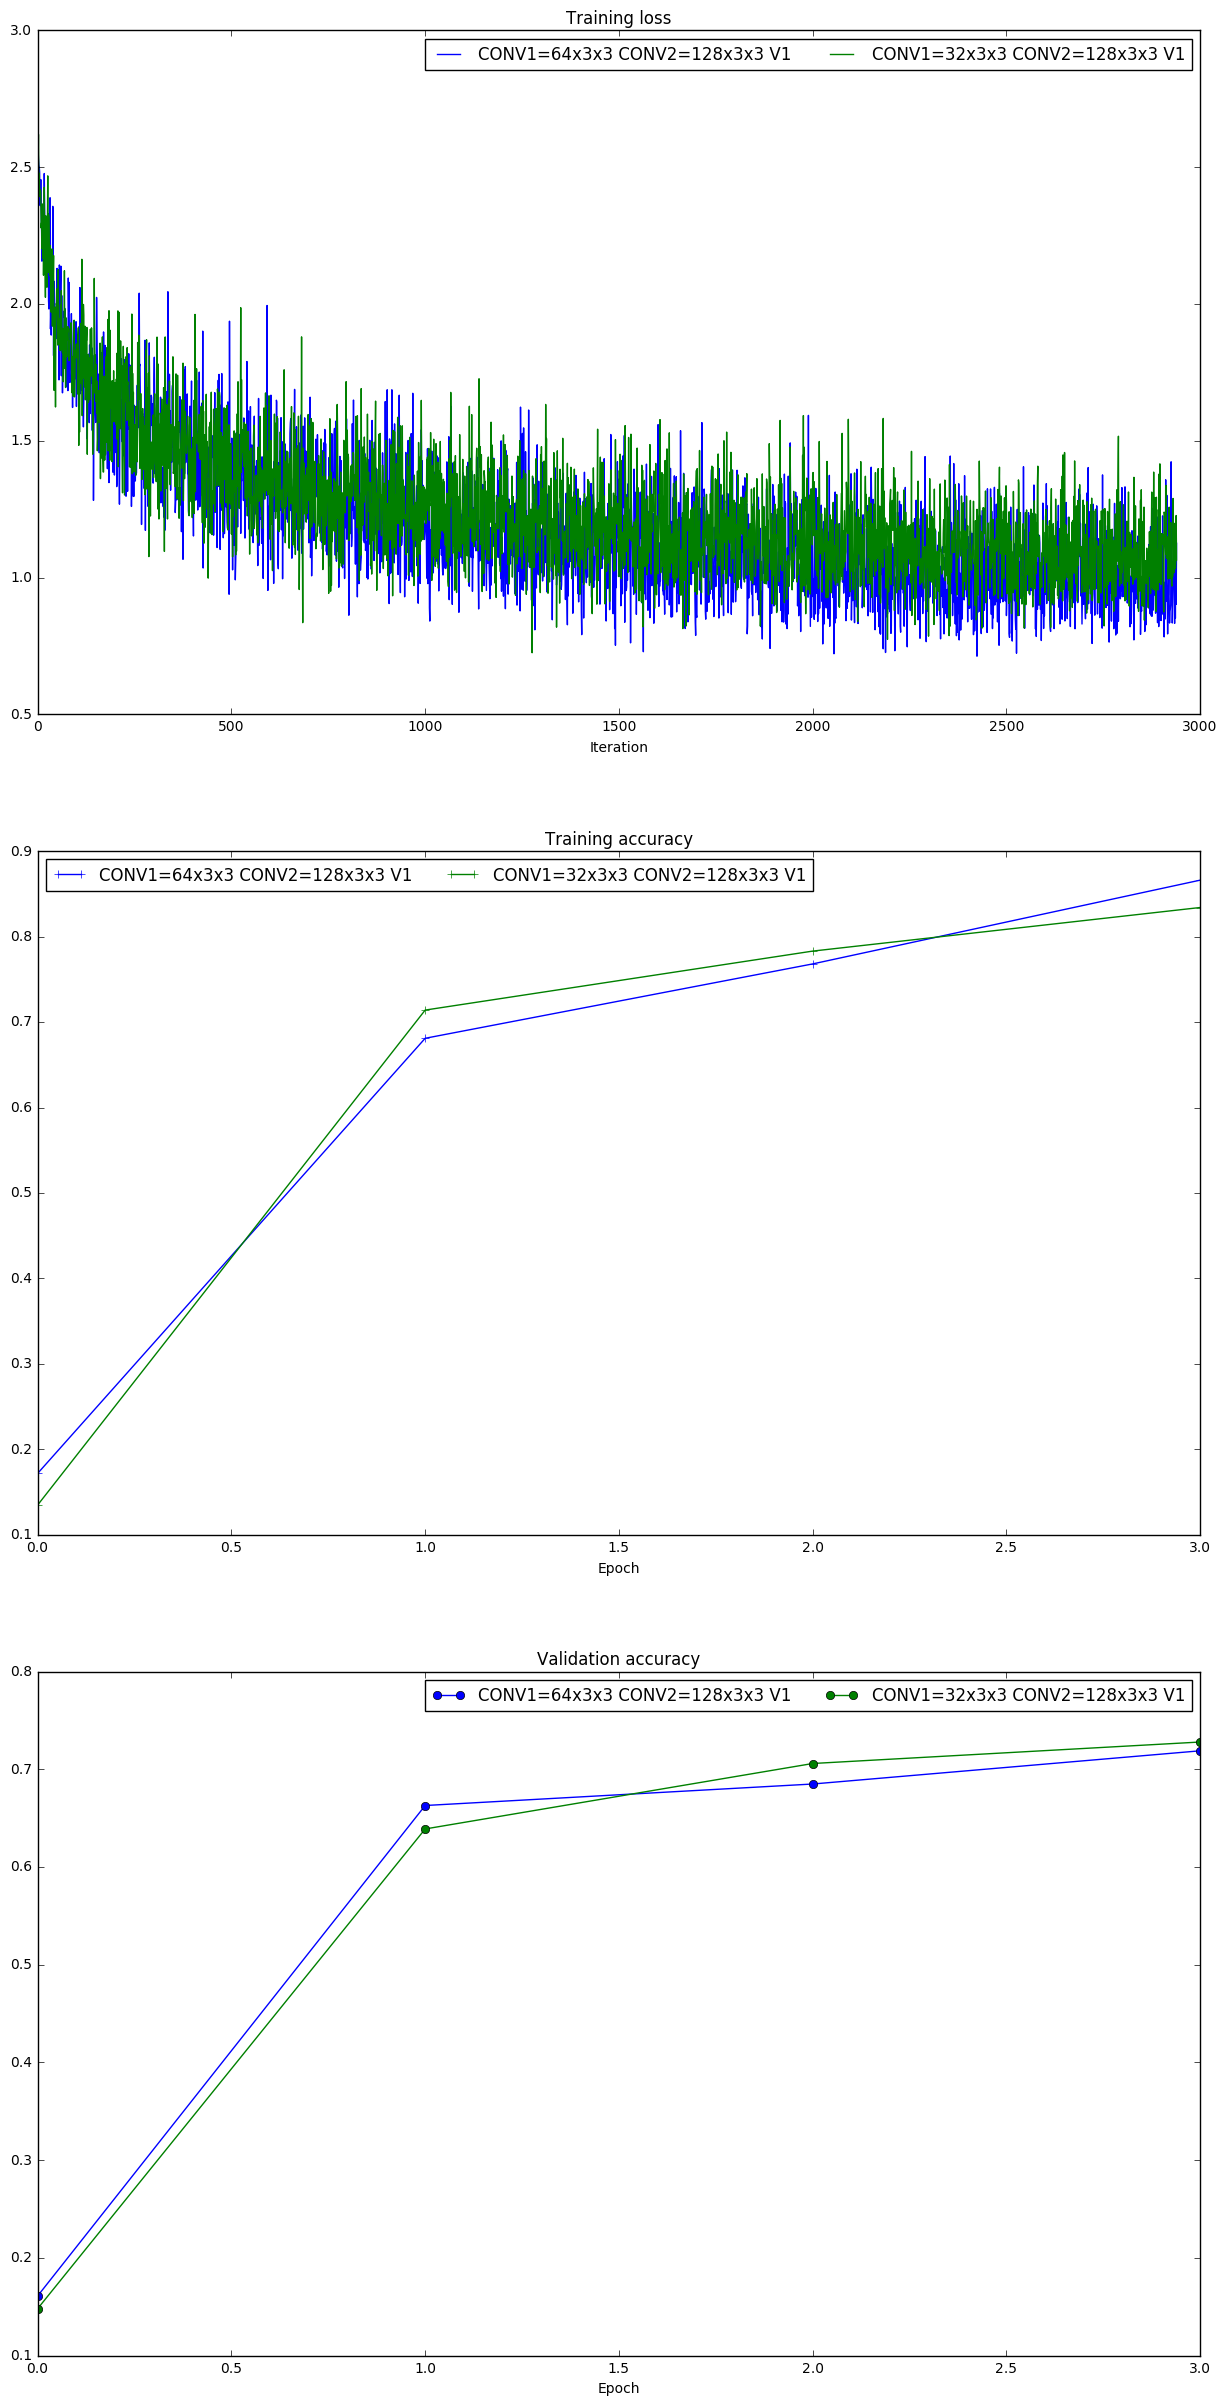

In [10]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

# Deep CNN - Architecture 2

A multi-layer convolutional network with an arbitrary number of CONV layers with the following architecture:
  
{conv - relu - conv - relu - max pool} x (L - 1) - affine - relu - affine - softmax

We tried out the following configurations (before the maxpool):

network_architectures =  {'CONV1=32x3x3 CONV2=32x3x3':([32,32],[3,3]),
                          'CONV1=64x3x3 CONV2=64x3x3':([64,64],[3,3]),
                          'CONV1=32x3x3 CONV1=33x3x3 CONV2=33x3x3':([32,32,32],[3,3,3]),
                        }
                        

# Test Deep CNN 2:
## Loss Check and Turn on Regularization
Sanity checks to run before expensive optimization: 
> Set regularization to 0.0, then perform a simple loss check: loss should be -log(1/N) for softmax 
>Turn up regularization, loss should go up

In [13]:
from cs231n.classifiers.convnet2 import *

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

model = DeepConvNet2(num_filters=[[32,64,128],[64,128,256],[512,512]], filter_sizes=[[3,3,3],[3,3,3],[3,3]],verbose=True)

loss, grads = model.loss(X, y,verbose=True)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

input dimension: 3 x 32 x 32


CONV Block: 1
  W & b in CONV layer 1
(32L, 3L, 3L, 3L)
(32L,)
CONV output dimension: 32 x 32 x 32
  W & b in CONV layer 2
(64L, 32L, 3L, 3L)
(64L,)
CONV output dimension: 64 x 32 x 32
  W & b in CONV layer 3
(128L, 64L, 3L, 3L)
(128L,)
CONV output dimension: 128 x 32 x 32
Maxpool dimension: 128 x 16 x 16


CONV Block: 2
  W & b in CONV layer 1
(64L, 128L, 3L, 3L)
(64L,)
CONV output dimension: 64 x 16 x 16
  W & b in CONV layer 2
(128L, 64L, 3L, 3L)
(128L,)
CONV output dimension: 128 x 16 x 16
  W & b in CONV layer 3
(256L, 128L, 3L, 3L)
(256L,)
CONV output dimension: 256 x 16 x 16
Maxpool dimension: 256 x 8 x 8


CONV Block: 3
  W & b in CONV layer 1
(512L, 256L, 3L, 3L)
(512L,)
CONV output dimension: 512 x 8 x 8
  W & b in CONV layer 2
(512L, 512L, 3L, 3L)
(512L,)
CONV output dimension: 512 x 8 x 8
Maxpool dimension: 512 x 4 x 4


W & b in FC layers:
(8192L, 100L)
(100L,)
(100L, 10L)
(10L,)
Dimensions of the W parameters
(0, 0)
(32L, 3L, 3L, 3L)
(0, 1)
